In [1]:
import sys

In [2]:
! echo $HOSTNAME

d9d4d6ec916d


In [3]:
#put these paths at the end, so the system python packages of the same name have precedence

In [4]:
sys.path.append('/global/common/cori/software/neon/1.3.0')

In [5]:
sys.path.append('/global/common/cori/software/neon/1.3.0/.venv/lib/python2.7/site-packages/')

In [6]:
sys.path;

In [7]:
import numpy as np

In [8]:
__author__ = 'racah'
import os
import pickle
import sys
from neon.util.argparser import NeonArgparser

import h5py
import matplotlib
from sklearn.manifold import TSNE
import numpy as np
matplotlib.use('agg')
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from conv_ae import ConvAe
from vis.viz import Viz
from util.helper_fxns import adjust_train_val_test_sizes


from util.data_loaders import load_dayabay_conv

In [9]:
# 1) Primary AD           10000 or 1
# 2) Delayed AD response  01000 or 2
# 3) Muon decay           00100 or 3
# 4) Flasher              00010 or 4
# 5) Other (background noise) 00001 or 5

In [10]:
def setup_parser():
        # parse the command line arguments
        parser = NeonArgparser(__doc__)

        parser.add_argument('--h5file')
        parser.add_argument('--test')
        parser.add_argument('--learn_rate')
        parser.add_argument('--bneck_width')
        parser.add_argument('--max_tsne_iter')
        parser.set_defaults(batch_size=128,h5file='/global/homes/p/pjsadows/data/dayabay/single/single_20000.h5',
                    serialize=2, epochs=100, learn_rate=0.0001, model_file=False,eval_freq=1, test=False, save_path='./results/model_files/conv-ae2',
                    wrap_pad_trick=False, cylinder_local_trick=False, bneck_width=10, max_tsne_iter=500)

        args = parser.parse_args()
        args.learn_rate = float(args.learn_rate)
        args.max_tsne_iter = int(args.max_tsne_iter)
        return args

In [11]:
#if __name__ == "__main__":
    
sys.argv = sys.argv[5:] # only for iPython to skip all the ipython command line arguments
args = setup_parser()

In [12]:
(X_train, y_train), (X_val,y_val), \
(X_test, y_test), nclass = load_dayabay_conv(path=args.h5file,
                                            clev_preproc=False, seed=6, eq_class=True, get_y=True )

X_train, y_train, X_val, y_val,\
X_test, y_test = adjust_train_val_test_sizes(args.batch_size, X_train,
                                             y_train, X_val, y_val, X_test, y_test)
X_train = X_train.reshape(X_train.shape[0],1,8,24)
X_val = X_val.reshape(X_val.shape[0],1,8,24)

In [14]:
args.epochs = 1
cae = ConvAe(args)
cae.fit(X_train)

Training with 26240 training example
Epoch 0   [Train |████████████████████|  205/205  batches, 7.19 cost, 23.31s]


In [15]:
feat = cae.extract(X_val)
gr_truth = np.argmax(y_val,axis =1) #convert from one-hot to normal

In [16]:
%matplotlib inline
v = Viz(gr_truth)

In [17]:
x_pc = v.get_pca(feat)

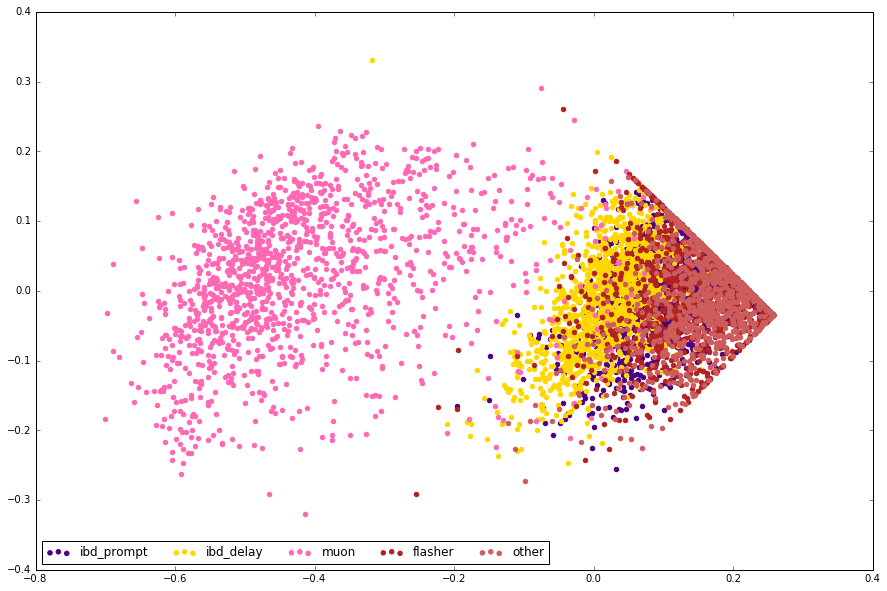

In [18]:
v.plot_features(x_pc,save=False)

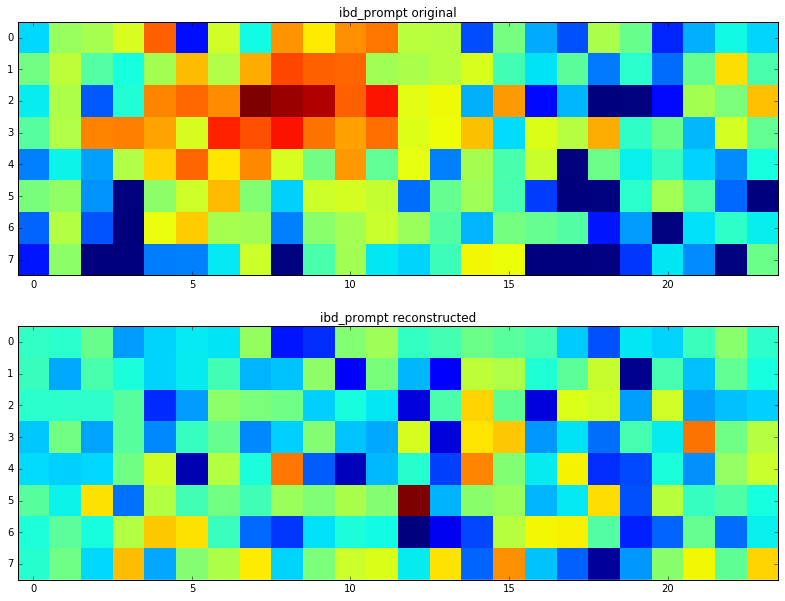

In [19]:
x_rec = cae.predict(X_val)
x_orig = X_val.reshape(X_val.shape[0], 192)
v.plot_reconstruction(x_orig[2], x_rec[2], indx=10, save=False)